<a href="https://colab.research.google.com/github/AlexNoonan-Syracuse/Lab6/blob/main/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
from google.colab import files
import io
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# download from http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv
uploaded = files.upload()


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving Zip_Zhvi_SingleFamilyResidence.csv to Zip_Zhvi_SingleFamilyResidence.csv


In [2]:


df1 = pd.read_csv(io.StringIO(uploaded['Zip_Zhvi_SingleFamilyResidence.csv'].decode('utf-8')))

# data exploration
#print(df1.isna().sum())
#print(df1.columns)
df1['RegionName'] = df1['RegionName'].astype(str)
print(df1.dtypes)
#print(df1.describe)
print(df1.head())

RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
StateName      object
               ...   
2019-11-30    float64
2019-12-31    float64
2020-01-31    float64
2020-02-29    float64
2020-03-31    float64
Length: 300, dtype: object
   RegionID  SizeRank RegionName  ... 2020-01-31 2020-02-29 2020-03-31
0     61639         0      10025  ...  1381453.0  1385737.0  1389268.0
1     84654         1      60657  ...   972038.0   973671.0   975642.0
2     61637         2      10023  ...  1478980.0  1479301.0  1474994.0
3     91982         3      77494  ...   335860.0   336037.0   336483.0
4     84616         4      60614  ...  1198277.0  1199900.0  1200980.0

[5 rows x 300 columns]


In [ ]:
# adding leading zeros to zipd code NEED to FIX
#leadingZeroStates = ['NJ', 'MA', 'ME','CT', 'NH', 'PR', 'RI', 'VT']
#zipfixes = df1.loc[df1['State'].isin(leadingZeroStates)]
#zipfixes['ZipCode'] = zipfixes['RegionName'].apply(lambda x: '0' + x)
# merging back to the main dataframe

# dftest = pd.merge(df1, zipfixes, how='left', left_on='RegionID', right_on='RegionID')


In [3]:
# time series of Hot Springs, Little Rock, Fayetteville, Searcy 
# Present all values from 1997 to present 
# Average at the metro area level

# reshape dataframe on
metro_areas = ['Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy']

dfAr =  df1[df1['State']=="AR"]
dfAr = dfAr[dfAr['City'].isin(metro_areas)]

# removing 1996 columns
dfAr = dfAr[dfAr.columns.drop(list(dfAr.filter(regex='1996-')))]
dfAr.reset_index(inplace=True)
dfAr = dfAr.drop(columns=['index','RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName','State', 'City', 'CountyName'])

dfAr['Metro'] = dfAr['Metro'].str.replace('Fayetteville-Springdale-Rogers', 'Fayetteville')
dfAr['Metro'] = dfAr['Metro'].str.replace('Little Rock-North Little Rock-Conway', 'Little Rock')
print(dfAr.head())

# aggregating averages across the metros and dates
dfAr_avg = dfAr.groupby('Metro').mean()

# pivoting on dates

# list of date columns
dateCols = list(dfAr_avg.filter(regex='-'))
list(dfAr_avg.index)

          Metro  1997-01-31  1997-02-28  ...  2020-01-31  2020-02-29  2020-03-31
0   Hot Springs     90258.0     91196.0  ...    163134.0    164485.0    166238.0
1  Fayetteville     96387.0     96430.0  ...    228725.0    229374.0    229775.0
2  Fayetteville    115676.0    116224.0  ...    242717.0    243144.0    243194.0
3        Searcy     76281.0     76540.0  ...    137024.0    136435.0    136386.0
4   Little Rock     51753.0     51946.0  ...     75124.0     76106.0     76895.0

[5 rows x 280 columns]


['Fayetteville', 'Hot Springs', 'Little Rock', 'Searcy']

In [4]:
# reshaping dfAr index = columnames, value = dates, column = metro

dfArFinal = pd.melt(dfAr, id_vars=dateCols, value_vars='Metro' )
dfArFinal = dfArFinal.groupby('value').mean()
dfArFinal.reset_index(inplace=True)
dfArFinal.rename(columns={'value':'Metro'}, inplace=True)

dfArFinal = pd.melt(dfArFinal, id_vars='Metro', value_vars=dateCols )
dfArFinal.rename(columns={'value':'Avg', 'variable':'Date'}, inplace=True)
dfArFinal['Date'] = pd.to_datetime(dfArFinal['Date'], infer_datetime_format=True)
dfArFinal.set_index('Date', inplace=True)
print(dfArFinal)


                   Metro            Avg
Date                                   
1997-01-31  Fayetteville  106636.000000
1997-01-31   Hot Springs   73681.500000
1997-01-31   Little Rock  105411.583333
1997-01-31        Searcy   64932.000000
1997-02-28  Fayetteville  107094.333333
...                  ...            ...
2020-02-29        Searcy  104397.500000
2020-03-31  Fayetteville  228817.000000
2020-03-31   Hot Springs  147991.500000
2020-03-31   Little Rock  184211.615385
2020-03-31        Searcy  104423.000000

[1116 rows x 2 columns]


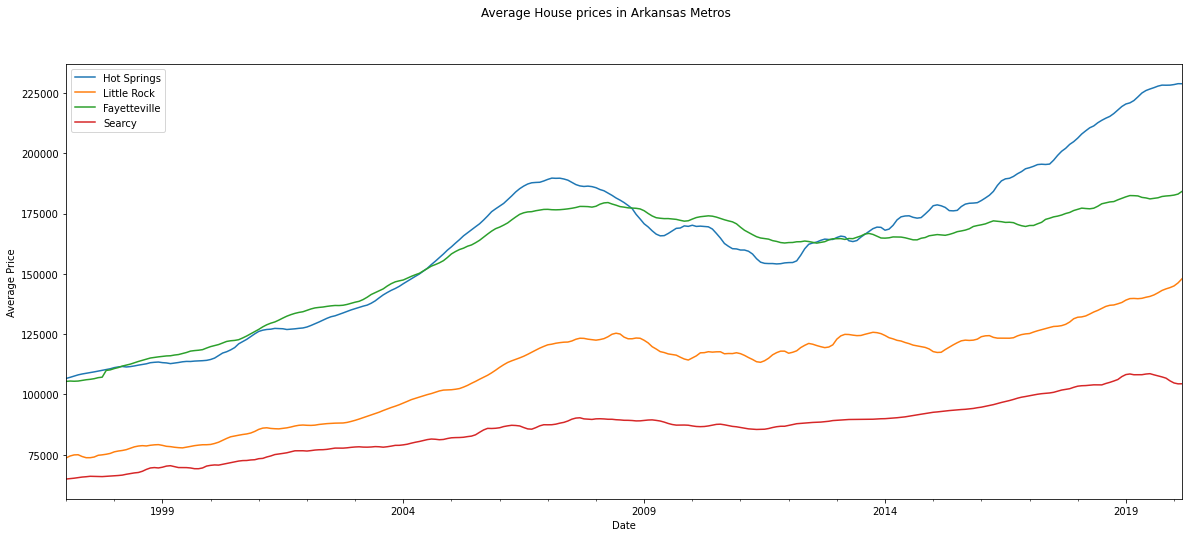

,Metro,Total Return%
0,Fayetteville,114.580000
1,Hot Springs,100.850000
2,Little Rock,74.750000
3,Searcy,60.820000


In [6]:
# time series plots of Avg price over time

fig, ax = plt.subplots()
fig.suptitle('Average House prices in Arkansas Metros')
fig.set_figheight(8)
fig.set_figwidth(20)

# Additional customizations
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
dfArFinal.groupby('Metro').plot( ax=ax, label='Metro')
plt.legend(metro_areas)
#dfArFinal.plot(ax=ax,label=dfArFinal['Metro'])
plt.show()

# return summary
summary_table = []
for i in range(len(metro_areas)):
  summary_table.append(return_calc(dfArFinal, metro_areas[i])) 

summary_table=pd.DataFrame(zip(metro_areas,summary_table),columns=["Metro",'Total Return%'])
summary_table.sort_values('Total Return%', ascending=False, ignore_index=True).style


In [43]:
# need to read in data to determine which metros to use 
# pick top 3 by pct change 

incomeGrowth = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/Lab6/main/Incomepermetro.csv",  error_bad_lines=False)
#print(incomeGrowth.dtypes)
incomeGrowth.sort_values('2019 PCt Change Rank', ascending=True, inplace=True)

topFiveIncome = incomeGrowth.nsmallest(5, '2019 PCt Change Rank')
topFiveIncome = topFiveIncome['Metropolitan Statistical Areas2'].str.split(',', expand=True)
topFiveIncome.rename(columns={0:'Metro', 1:'State'}, inplace=True)
topFiveIncome.reset_index(inplace=True)
topFiveIncome.drop(columns='index', inplace=True)
#topFiveIncome = list(topFiveIncome['Metropolitan Statistical Areas2'])
topFiveIncome['Metro'] = topFiveIncome['Metro'].str.replace('Visalia', 'Visalia-Porterville')

print(topFiveIncome)
modelingdf = pd.merge(topFiveIncome, df1, how='inner', on='Metro')
print(modelingdf)
print(modelingdf.columns)
metroList = modelingdf['Metro'].unique()
modelingdateCols = list(modelingdf.filter(regex='-'))

for dates in modelingdateCols:
    colname = str(dates) + 'Rollmean3'
    #print(colname)
    modelingdf[colname]  = modelingdf[dates].rolling( 3,center=True,min_periods=1).mean()
    modelingdf[dates] = modelingdf[colname]
dropCols = list(modelingdf.filter(regex='Rollmean3'))
#drop orignal date columns
modelingdf.drop(columns=dropCols, inplace=True) 

#rename moving average columns

#modelingdf = modelingdf.rename(columns=lambda x: x[:-8] if 'Rollmean3' in x  else x)
print(modelingdf.columns)
print(metroList)

                 Metro State
0            El Centro    CA
1                Chico    CA
2     Hanford-Corcoran    CA
3  Visalia-Porterville    CA
4          Panama City    FL
          Metro State_x  RegionID  ...  2020-01-31 2020-02-29 2020-03-31
0     El Centro      CA     96750  ...    243740.0   245573.0   247389.0
1     El Centro      CA     96740  ...    249671.0   252738.0   255387.0
2     El Centro      CA     96738  ...    240275.0   242748.0   245117.0
3     El Centro      CA     96756  ...    270918.0   273297.0   275827.0
4     El Centro      CA     96775  ...    163163.0   164654.0   166351.0
..          ...     ...       ...  ...         ...        ...        ...
80  Panama City      FL     72021  ...     88657.0    89210.0    89762.0
81  Panama City      FL     72022  ...    168822.0   169796.0   170759.0
82  Panama City      FL     72017  ...    952767.0   950561.0   950677.0
83  Panama City      FL     71999  ...     99937.0   101884.0   103785.0
84  Panama City      FL

                          Metro         Median
Date                                          
1996-01-31     Hanford-Corcoran   95645.000000
1996-01-31          Panama City   97946.000000
1996-01-31  Visalia-Porterville   84261.000000
1996-02-29            El Centro   43697.000000
1996-02-29     Hanford-Corcoran   95496.000000
...                         ...            ...
2020-03-31                Chico  249438.333333
2020-03-31            El Centro  223782.333333
2020-03-31     Hanford-Corcoran  178574.000000
2020-03-31          Panama City  225755.833333
2020-03-31  Visalia-Porterville  212304.000000

[1442 rows x 2 columns]


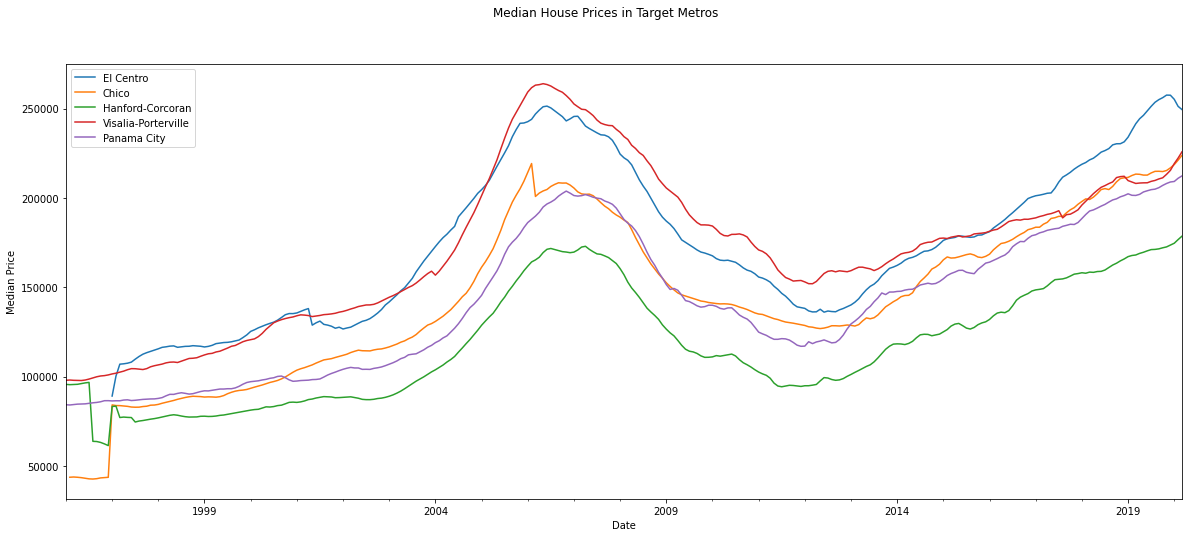

,Metro,Total Return%
0,El Centro,412.120000
1,Chico,179.870000
2,Visalia-Porterville,151.960000
3,Panama City,130.490000
4,Hanford-Corcoran,86.710000


In [34]:
# transforming modeldf so time series analysis for the plots
# reshaping dfAr index = columnames, value = dates, column = metro

modelingdfplot = pd.melt(modelingdf, id_vars=modelingdateCols, value_vars='Metro' )
modelingdfplot = modelingdfplot.groupby('value').median()
modelingdfplot.reset_index(inplace=True)
modelingdfplot.rename(columns={'value':'Metro'}, inplace=True)

modelingdfplot = pd.melt(modelingdfplot, id_vars='Metro', value_vars=modelingdateCols )
modelingdfplot.rename(columns={'value':'Median', 'variable':'Date'}, inplace=True)

modelingdfplot['Date'] = pd.to_datetime(modelingdfplot['Date'], infer_datetime_format=True)
modelingdfplot.set_index('Date', inplace=True)
modelingdfplot.dropna(inplace=True)
print(modelingdfplot)
# time series plots of Avg price over time

fig, ax = plt.subplots()
fig.suptitle('Median House Prices in Target Metros')
fig.set_figheight(8)
fig.set_figwidth(20)

# Additional customizations
ax.set_xlabel('Date')
ax.set_ylabel('Median Price')
modelingdfplot.groupby('Metro').plot( ax=ax, label='Metro')
plt.legend(metroList)
#dfArFinal.plot(ax=ax,label=dfArFinal['Metro'])
plt.show()

# return summary
returnSummary_table = []
for i in range(len(metroList)):
  returnSummary_table.append(return_calc(modelingdfplot, metroList[i])) 

returnSummary_table=pd.DataFrame(zip(metroList,returnSummary_table),columns=["Metro",'Total Return%'])
returnSummary_table.sort_values('Total Return%', ascending=False, ignore_index=True).style


In [5]:
def return_calc(df, metro):
    # takes in df and retro an calculates return
    df1 = df.loc[df['Metro']==metro]
    return round((df1.iloc[-1,1] - df1.iloc[0,1])/df1.iloc[0,1]*100,2)
    

In [44]:
# melting the full dataframe to create forecast of median house price per zip code from 2018 (1997-2017) as training set

#print(*df1.columns, sep = "\n")
# region name == zipcode
print(modelingdf.head())
# dropping columns 
modelingdf = modelingdf[modelingdf.columns.drop(list(modelingdf.filter(regex='1996-')))]
modelingdf.reset_index(inplace=True)
modelingdf = modelingdf.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'City', 'CountyName'])

mainDateCols = list(modelingdf.filter(regex='-'))
modelingdf = pd.melt(modelingdf, id_vars=mainDateCols, value_vars='RegionName', value_name='ZipCode' )
modelingdf = modelingdf.groupby('ZipCode').median()

modelingdf.reset_index(inplace=True)
modelingdf = pd.melt(modelingdf, id_vars='ZipCode', value_vars=mainDateCols , var_name='Date', value_name='Median_Home_Value')
modelingdf = pd.pivot_table(data=modelingdf,
    index='Date',
    columns='ZipCode',
   values = 'Median_Home_Value'
    ).reset_index()
modelingdf['Date'] = pd.to_datetime(modelingdf['Date'], infer_datetime_format=True)
modelingdf.set_index('Date', inplace=True)
modelingdf.head()



       Metro State_x  RegionID  ...     2020-01-31     2020-02-29     2020-03-31
0  El Centro      CA     96750  ...  246705.500000  249155.500000  251388.000000
1  El Centro      CA     96740  ...  244562.000000  247019.666667  249297.666667
2  El Centro      CA     96738  ...  253621.333333  256261.000000  258777.000000
3  El Centro      CA     96756  ...  224785.333333  226899.666667  229098.333333
4  El Centro      CA     96775  ...  218637.333333  221112.000000  223782.333333

[5 rows x 301 columns]


ZipCode,32401,32404,32405,32407,32408,32409,32413,32438,32444,32449,32456,32461,32465,32466,92227,92231,92233,92243,92249,92250,92251,92273,92274,92275,92281,93201,93202,93204,93207,93212,93218,93219,93221,93223,93227,93230,93235,93239,93244,93245,...,93265,93266,93267,93270,93271,93272,93274,93277,93282,93286,93291,93292,93603,93615,93618,93647,93666,93670,95914,95916,95917,95925,95926,95928,95930,95938,95941,95942,95948,95954,95958,95965,95966,95968,95969,95972,95973,95974,95978,96092
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997-01-31,97302.666667,109493.5,116339.000000,101502.666667,104656.666667,98294.000000,93840.000000,440163.0,94767.333333,NaN,89653.0,259952.0,87743.0,259952.0,89608.333333,84172.333333,107017.0,81882.5,100316.0,81432.333333,76477.000000,NaN,78098.000000,124706.0,NaN,NaN,83264.0,72060.5,64423.0,60857.0,64423.0,91155.666667,89062.000000,78211.000000,43375.0,104700.0,66185.666667,97871.0,64423.0,82778.500000,...,88347.000000,83264.0,90627.666667,72897.5,72111.333333,47984.666667,91122.5,106236.000000,88135.0,86397.333333,116693.000000,111012.333333,NaN,81855.5,100654.333333,88381.666667,NaN,NaN,NaN,89127.0,89127.0,NaN,129005.5,129005.500000,NaN,83875.000000,NaN,NaN,90245.500000,82660.666667,104700.0,82053.500000,67491.000000,89127.000000,NaN,NaN,133305.000000,NaN,NaN,NaN
1997-02-28,97734.000000,110118.5,116924.333333,101922.000000,105134.000000,98336.666667,94185.000000,443694.0,95163.666667,NaN,89373.5,261880.5,87561.5,261880.5,89096.333333,83803.000000,107536.0,81614.5,100254.5,81486.333333,76342.333333,NaN,77940.000000,124142.0,NaN,NaN,83489.0,72017.5,65116.0,82706.5,65116.0,91015.333333,89218.666667,78146.333333,43128.0,104572.0,66146.000000,97981.0,65116.0,89896.666667,...,88152.333333,83489.0,90395.333333,72660.5,72008.666667,48095.333333,91205.0,106270.666667,88603.0,86488.666667,116735.333333,111084.666667,NaN,81591.0,100728.333333,88498.333333,NaN,NaN,NaN,96376.0,72833.0,NaN,128788.0,134262.333333,NaN,111110.666667,NaN,56411.000000,109144.000000,83277.666667,104277.0,79934.333333,95805.666667,72833.000000,124445.0,NaN,117685.666667,NaN,NaN,NaN
1997-03-31,98305.666667,110651.5,117521.333333,102512.333333,105510.666667,98547.333333,94585.666667,447911.0,95496.666667,NaN,89410.5,263736.0,87027.5,263736.0,89006.000000,83772.666667,107626.0,81551.0,100359.5,81493.666667,76457.000000,NaN,78082.666667,123929.0,NaN,NaN,69708.5,71718.0,64889.0,82385.5,64889.0,90724.333333,89093.666667,78140.000000,43266.0,104164.0,66049.333333,77119.5,64889.0,89564.000000,...,87855.333333,69708.5,89811.000000,72199.0,71822.000000,48247.000000,91081.5,106011.333333,89216.0,86481.666667,116496.000000,110898.333333,NaN,81252.0,100593.666667,88427.666667,NaN,NaN,112482.0,97505.5,73931.5,NaN,128794.5,134147.000000,NaN,112001.333333,121443.0,94128.333333,110009.666667,84329.333333,103921.0,80797.333333,96216.666667,83794.666667,125156.5,NaN,117869.000000,NaN,NaN,NaN
1997-04-30,98663.666667,111246.5,117797.000000,103069.333333,105904.666667,99039.333333,94810.333333,454506.0,95846.000000,NaN,89932.5,266868.5,86961.0,266868.5,88586.666667,83560.666667,107919.0,81244.0,100658.0,81756.333333,76644.666667,NaN,78379.000000,123366.0,NaN,NaN,69251.5,71096.5,64403.0,82223.0,64403.0,90228.000000,89222.333333,78534.333333,43325.0,103713.0,66163.666667,77364.0,64403.0,89230.333333,...,87491.666667,69251.5,89148.000000,72268.5,71717.666667,48596.000000,91250.5,106092.000000,90029.0,86891.000000,116707.000000,111126.333333,NaN,80916.5,100756.000000,88759.666667,NaN,NaN,112569.0,98881.5,75377.0,NaN,128721.5,134176.333333,NaN,112848.333333,120748.0,94533.333333,111096.666667,85928.000000,103245.0,81788.333333,96745.000000,85048.000000,125566.5,NaN,118052.000000,NaN,NaN,NaN
1997-05-31,99309.333333,112387.5,118323.333333,103869.333333,106816.000000,99741.666667,95330.666667,457713.0,96632.666667,NaN,90711.5,268480.0,87236.5,268480.0,88285.000000,83361.666667,108257.0,80848.0,101301.5,82223.000000,7688

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ZipCode
99587    float64
dtype: object
First difference
ADF Statistic: -2.875972
p-value: 0.048214


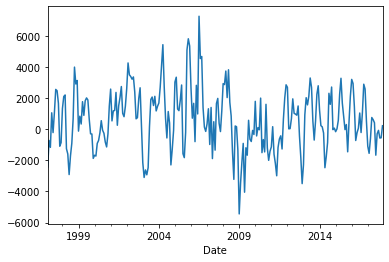

AR: 1 MA: 1 AIC: 4359.38544338113
AR: 1 MA: 2 AIC: 4248.243689251675
AR: 1 MA: 3 AIC: 4250.886152543454
AR: 2 MA: 1 AIC: 4358.504058946049
AR: 2 MA: 2 AIC: 4250.225775459706
AR: 2 MA: 3 AIC: 4239.521513044917
AR: 3 MA: 1 AIC: 4333.059542088766
AR: 3 MA: 2 AIC: 4252.219067298888
AR: 3 MA: 3 AIC: 4240.163012510045
Fitted model
const            616.636291
ar.L1.D.99587     -1.001559
ar.L2.D.99587     -0.112272
ma.L1.D.99587      2.000397
ma.L2.D.99587      2.000397
ma.L3.D.99587      1.000000
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.99587   No. Observations:                  250
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2112.761
Method:                       css-mle   S.D. of innovations           1104.746
Date:                Fri, 20 Aug 2021   AIC                           4239.522
Time:                        00:56:16   BIC                           4264.172
Sample:         

In [15]:
# put df5 into an arima model

#Testing with zip 99587

subsetdf = df5[['99587']]
print(subsetdf.dtypes)
# subsetting from 1997-2017
traindf =subsetdf.loc['1997-01-31':'2017-12-31']
testdf = subsetdf.loc['2018-01-31':]
#print(testdf.head())

# create a differenced series
traindf['firstDiff'] = traindf['99587'].diff(periods=1)
traindf['log'] = np.log(traindf['99587'])
# adf test
traindf = traindf.replace([np.inf, -np.inf], np.nan).dropna()
result1 = adfuller(traindf['firstDiff'])
print('First difference')
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])


# result2 = adfuller(traindf['log'])
# print('Log')
# print('ADF Statistic: %f' % result2[0])
# print('p-value: %f' % result2[1])

# ARIMA Model

# need to create 

traindf['firstDiff'].plot()
plt.show()


#print(testdf.head())


for pindex in range(3):
    for qindex in range(3):
      p = pindex + 1 
      q = qindex + 1
      Model1 = ARIMA(traindf['99587'], order = (p,1,q)).fit()
      print('AR:', p , 'MA:', q, 'AIC:', Model1.aic)
      # need a dictionary to save this p,q, aic

Fitted_model = ARIMA(traindf['99587'], order = (2,1,3)).fit()
# fitted model parameters
print("Fitted model")
print(Fitted_model.params)
print(Fitted_model.summary())

Test RMSE: 34516.781


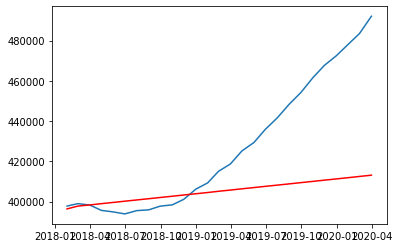

In [16]:

# forecasting
predictions = list()

# walk-forward validation
Fitted_model = ARIMA(traindf['99587'], order = (3,1,2)).fit()
predictions = Fitted_model.forecast(steps=len(testdf))[0]
predictionsdf = pd.DataFrame({'Date':testdf.index,'Predictions': predictions })
predictionsdf.set_index('Date', inplace=True)

# evaluate forecasts
rmse = sqrt(mean_squared_error(testdf['99587'], predictions))
print('Test RMSE: %.3f' % rmse)


# plot forecasts against actual outcomes
plt.plot(testdf['99587'])
plt.plot(predictionsdf, color='red')
plt.show()